In [190]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [191]:
all_my_features=pd.read_csv('data/all_my_features.csv')

In [192]:
all_my_features=all_my_features[all_my_features['gameweek']>4]

In [193]:
label_encoder = LabelEncoder()
all_my_features['label'] = label_encoder.fit_transform(all_my_features['result'])

In [194]:
train = all_my_features[~all_my_features['competition'].str.contains('English|German', regex=True)]


In [195]:
val=all_my_features[all_my_features['competition'].str.contains('German')]

In [196]:
test=all_my_features[all_my_features['competition'].str.contains('English')]

In [197]:
X_train=train.drop(columns=['gameweek', 'dateutc', 'competition', 'result', 'label'])
y_train=train['label']

In [198]:
X_val=val.drop(columns=['gameweek', 'dateutc', 'competition', 'result', 'label'])
y_val=val['label']

In [199]:
X_val

,home.wins_home,home.draws_home,home.losses_home,away.wins_away,away.draws_away,away.losses_away,home.GoalsPerGame,home.GoalsPerGame_last3,home.ConcededPerGame,home.ConcededPerGame_last3,...,away.avg_accurate_pass_ratio,away.avg_launch_count,away.avg_shot_count,away.avg_shots_on_target_ratio,away.avg_concede_late_count,away.num_started_prev,away.age,away.height,away.weight,away.teams_player_rating
225,0.5000,0.0000,0.5000,0.0000,0.0000,1.0000,1.250000,1.333333,1.250000,1.666667,...,0.857627,15.250000,10.500000,0.249002,0.000000,9,24.272727,182.818182,78.454545,0.001042
227,1.0000,0.0000,0.0000,0.5000,0.0000,0.5000,1.750000,1.666667,0.750000,1.000000,...,0.875494,4.250000,19.000000,0.422105,0.000000,5,26.181818,183.181818,77.454545,0.013267
228,0.5000,0.5000,0.0000,0.5000,0.0000,0.5000,1.750000,2.333333,1.000000,1.000000,...,0.824101,11.250000,15.000000,0.333454,0.000000,2,24.727273,181.909091,76.272727,0.008603
229,0.0000,0.5000,0.5000,0.0000,0.5000,0.5000,0.500000,0.666667,1.250000,0.666667,...,0.785315,10.500000,9.500000,0.276389,0.500000,9,25.454545,182.181818,74.636364,0.003722
233,0.0000,0.0000,1.0000,0.5000,0.5000,0.0000,0.250000,0.333333,3.000000,3.666667,...,0.791427,12.000000,14.750000,0.312187,0.250000,8,27.181818,183.545455,79.181818,0.005452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1753,0.5000,0.3750,0.1250,0.3750,0.1875,0.4375,1.575758,1.666667,1.121212,1.333333,...,0.789882,16.393939,10.363636,0.384744,0.515152,9,25.727273,183.818182,76.909091,0.006228
1754,0.4375,0.3125,0.2500,0.1250,0.3750,0.5000,1.666667,0.000000,1.272727,1.666667,...,0.780634,16.151515,11.545455,0.338547,0.393939,5,25.454545,185.545455,79.909091,0.007786
1755,0.2500,0.3125,0.4375,0.2500,0.2500,0.5000,0.818182,1.333333,1.575758,1.333333,...,0.838807,10.696970,12.030303,0.363678,0.272727,8,25.727273,184.727273,79.181818,0.008599
1756,0.4375,0.1875,0.3750,0.1875,0.3125,0.5000,1.121212,1.666667,1.515152,1.000000,...,0.795156,13.727273,11.090909,0.384661,0.242424,9,25.181818,182.090909,75.181818,0.004681


### Scaling 

In [200]:
scaling_columns=X_train.columns

In [201]:
scaler = StandardScaler()

In [202]:
# Scale the numeric features in the training set
X_train = scaler.fit_transform(X_train)

In [203]:
X_val=scaler.transform(X_val)

In [204]:
test=test.copy()
test[scaling_columns]=scaler.transform(test[scaling_columns])

### sorting test data by date

In [205]:
test['date']=pd.to_datetime(test['dateutc']).dt.date

In [206]:

test = test.sort_values('date')
unique_dates = test['date'].unique()

In [207]:
test.drop(columns=['gameweek', 'dateutc', 'competition', 'result'], inplace=True)

### Define the Neural Network Model

In [208]:
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_dim)
        self.dropout = nn.Dropout(0.5)  # Dropout to prevent overfitting

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Optimizer and learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Add weight decay for regularization


### Coverting data to tensors

In [209]:
# Convert the data into PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long) 


In [210]:
# Create a DataLoader for batching (optional, but useful for large datasets)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [211]:
# Convert the data into PyTorch tensors
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)  
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long) 

# Create a DataLoader for batching (optional, but useful for large datasets)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [212]:
test_batch['label']

178    2
Name: label, dtype: int64

In [213]:
# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[1]  # Number of features
output_dim = 3  # Number of classes (update based on your data)

model = NeuralNetwork(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Initialize variables to track progress
predictions = []
accuracies = []
batchsizes = []
acc_batch = []
thresholds = [0.5, 0.4, 0.5] 

In [214]:

# Train the model using the training data for a fixed number of epochs
epochs = 20
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0

    # Iterate through training batches
    for X_batch, y_batch in train_loader:  # Assuming you have a DataLoader for training
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(X_batch)  # Forward pass
        loss = criterion(outputs, y_batch)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()

    # Print training loss for the epoch
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {running_loss:.4f}")

    # Optionally validate after each epoch (if you have a validation set)
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():  # No gradients for validation
        for X_val_batch, y_val_batch in val_loader:  # Assuming you have a DataLoader for validation
            outputs = model(X_val_batch)
            loss = criterion(outputs, y_val_batch)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted_classes = torch.max(outputs, 1)
            acc = accuracy_score(y_val_batch, predicted_classes)
            val_acc += acc

    # Print validation loss and accuracy
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_acc/len(val_loader):.4f}")

# Now that training is complete, evaluate on the test set (don't update model here)
model.eval()  # Set model to evaluation mode for final testing
test_predictions = []
test_accuracies = []

Epoch [1/20], Train Loss: 32.9214
Validation Loss: 1.0420, Validation Accuracy: 0.4802
Epoch [2/20], Train Loss: 30.7653
Validation Loss: 1.0587, Validation Accuracy: 0.4826
Epoch [3/20], Train Loss: 30.0001
Validation Loss: 1.0587, Validation Accuracy: 0.4816
Epoch [4/20], Train Loss: 29.5500
Validation Loss: 1.0722, Validation Accuracy: 0.4896
Epoch [5/20], Train Loss: 29.3306
Validation Loss: 1.0661, Validation Accuracy: 0.4965
Epoch [6/20], Train Loss: 29.2915
Validation Loss: 1.0839, Validation Accuracy: 0.4767
Epoch [7/20], Train Loss: 28.3918
Validation Loss: 1.0962, Validation Accuracy: 0.4514
Epoch [8/20], Train Loss: 27.9142
Validation Loss: 1.1064, Validation Accuracy: 0.4712
Epoch [9/20], Train Loss: 27.8360
Validation Loss: 1.1103, Validation Accuracy: 0.4732
Epoch [10/20], Train Loss: 27.0250
Validation Loss: 1.1267, Validation Accuracy: 0.4851
Epoch [11/20], Train Loss: 26.5587
Validation Loss: 1.1507, Validation Accuracy: 0.4067
Epoch [12/20], Train Loss: 26.1974
Valida

In [215]:

for date in unique_dates:
    # Filter test data for the current date
    test_batch = test[test['date'] == date]
    X_test_batch = test_batch.drop(columns=['label', 'date'])
    y_test_batch = test_batch['label']
    
    # Convert test batch to tensors
    X_test_batch_tensor = torch.tensor(X_test_batch.values, dtype=torch.float32)
    y_test_batch_tensor = torch.tensor(y_test_batch.values, dtype=torch.long)
    
    # Make predictions for the current batch
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        y_pred_batch = model(X_test_batch_tensor)
    #uncomment this to get back to default
        _, predicted_classes = torch.max(y_pred_batch, 1)  # Get predicted class labels

    ################### comment this to get back to default
    #y_pred_proba = F.softmax(y_pred_batch, dim=1)  # Apply softmax to get probabilities
        
    # Adjust threshold for each class
    #predicted_classes = torch.argmax(y_pred_proba, dim=1)  # Default decision with max prob
        
    # Apply custom threshold for class 1 (for example, making class 1 more likely)
    #for i, threshold in enumerate(thresholds):
    #    predicted_classes[(y_pred_proba[:, i] > threshold)] = i
    ################
    
    # Collect predictions
    predictions.extend(predicted_classes.numpy())
    
    # Calculate and store metrics
    acc = accuracy_score(y_test_batch, predicted_classes.numpy())
    accuracies.append(acc)
    batchsizes.append(len(X_test_batch))
    acc_batch.append(acc * len(X_test_batch))

    print(f"Date: {date} - Accuracy: {acc:.4f} - BatchSize: {len(X_test_batch)}")

    # Update model with the current batch
    # Training mode
    model.train()  # Set the model to training mode
    
    # Concatenate current test data to the training data
    X_all = np.concatenate([X_train, X_test_batch.to_numpy()], axis=0)
    y_all = pd.concat([y_train, y_test_batch])

    # Convert to tensors
    X_all_tensor = torch.tensor(X_all, dtype=torch.float32)
    y_all_tensor = torch.tensor(y_all.values, dtype=torch.long)
    
    # Train the model with the updated data
    optimizer.zero_grad()  # Zero the gradients
    outputs = model(X_all_tensor)  # Forward pass
    loss = criterion(outputs, y_all_tensor)  # Compute loss
    loss.backward()  # Backward pass
    optimizer.step()  # Update weights
    
    # Update training data
    X_train = X_all
    y_train = y_all

# Collect all predictions for further evaluation if needed
test['predictions'] = predictions



Date: 2017-09-15 - Accuracy: 0.0000 - BatchSize: 1
Date: 2017-09-16 - Accuracy: 0.4286 - BatchSize: 7
Date: 2017-09-17 - Accuracy: 0.5000 - BatchSize: 2
Date: 2017-09-23 - Accuracy: 0.3750 - BatchSize: 8
Date: 2017-09-24 - Accuracy: 0.0000 - BatchSize: 1
Date: 2017-09-25 - Accuracy: 0.0000 - BatchSize: 1
Date: 2017-09-30 - Accuracy: 0.2857 - BatchSize: 7
Date: 2017-10-01 - Accuracy: 0.6667 - BatchSize: 3
Date: 2017-10-14 - Accuracy: 0.4286 - BatchSize: 7
Date: 2017-10-15 - Accuracy: 0.0000 - BatchSize: 2
Date: 2017-10-16 - Accuracy: 0.0000 - BatchSize: 1
Date: 2017-10-20 - Accuracy: 0.0000 - BatchSize: 1
Date: 2017-10-21 - Accuracy: 0.4286 - BatchSize: 7
Date: 2017-10-22 - Accuracy: 0.5000 - BatchSize: 2
Date: 2017-10-28 - Accuracy: 0.4286 - BatchSize: 7
Date: 2017-10-29 - Accuracy: 0.5000 - BatchSize: 2
Date: 2017-10-30 - Accuracy: 0.0000 - BatchSize: 1
Date: 2017-11-04 - Accuracy: 0.5000 - BatchSize: 6
Date: 2017-11-05 - Accuracy: 0.5000 - BatchSize: 4
Date: 2017-11-18 - Accuracy: 0.

In [216]:
# Print classification report
from sklearn.metrics import classification_report
print(classification_report(test['label'], predictions))


              precision    recall  f1-score   support

           0       0.40      0.46      0.43        94
           1       0.33      0.20      0.25        93
           2       0.54      0.61      0.57       153

    accuracy                           0.46       340
   macro avg       0.42      0.43      0.42       340
weighted avg       0.44      0.46      0.45       340



In [217]:


# Generate confusion matrix
cm = confusion_matrix(test['label'], predictions)

# Print confusion matrix
print(cm)

[[43 18 33]
 [27 19 47]
 [38 21 94]]


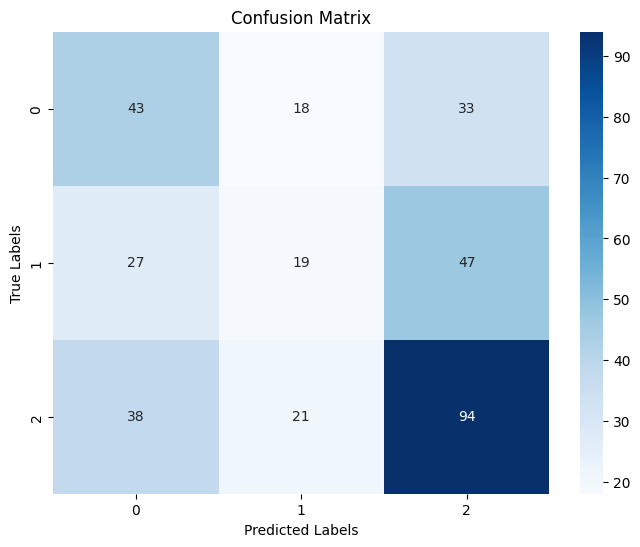

In [218]:


# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])

# Add labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show plot
plt.show()

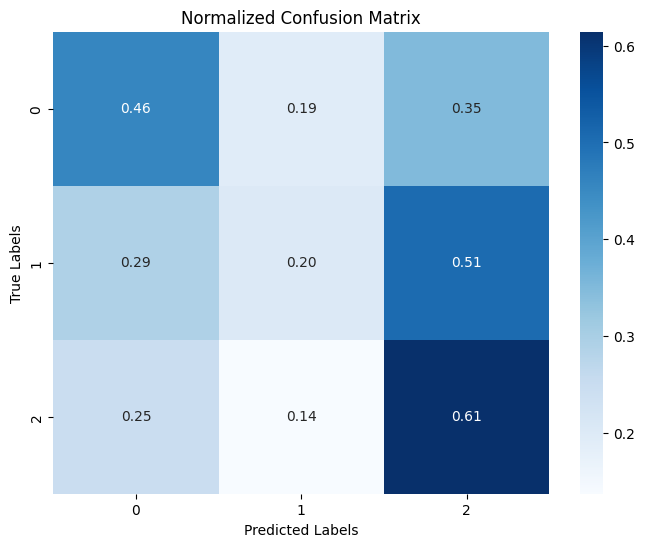

In [219]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualize the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])

# Add labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')

# Show plot
plt.show()